# Beta Chain Model Comparisons

## Setup

In [1]:
import os
from pathlib import Path
import sys

if '__project_dir__' not in globals():
    __project_dir__ = Path.cwd().parents[1].resolve()

sys.path.append(__project_dir__)
os.chdir(__project_dir__)

In [2]:
import json
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn

seaborn.set_theme()
seaborn.set_style('white')
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

In [3]:
BENCHMARKING_PARENT_DIR = Path('benchmarks_beta')

In [4]:
metric_dicts = []

for model in BENCHMARKING_PARENT_DIR.iterdir():
    with open(model/'summary.json', 'r') as f:
        metric_dicts.append(json.load(f))

## Average Precisions

### Dash

In [5]:
dash_avg_precisions = {mdict["model_name"]: mdict["dash"]["avg_precision"] for mdict in metric_dicts}
dash_avg_precisions = pd.DataFrame.from_dict(dash_avg_precisions, orient="index")
dash_avg_precisions = dash_avg_precisions.sort_values(by=0)

<AxesSubplot: >

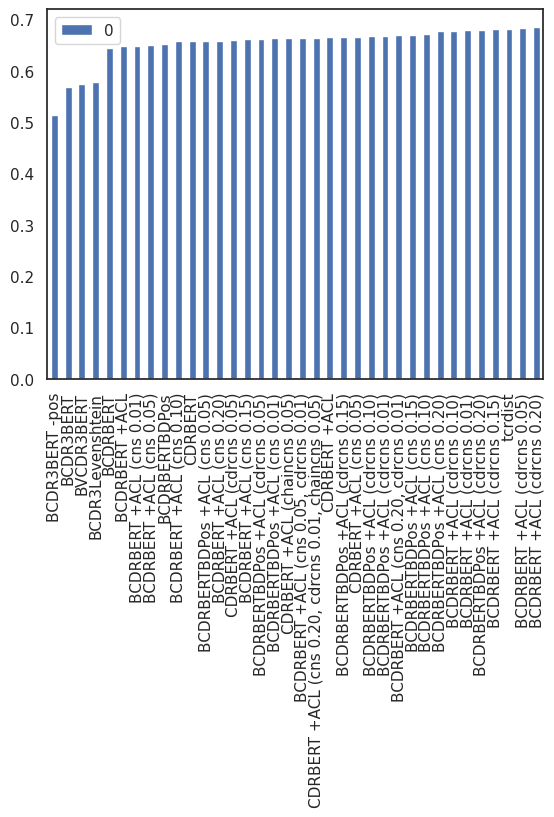

In [6]:
dash_avg_precisions.plot(kind="bar")

In [7]:
def clean_plot(metrics, models):
    embedding_info = metrics.loc[models]
    return embedding_info.plot(kind='bar', legend=False)

(0.6, 0.7)

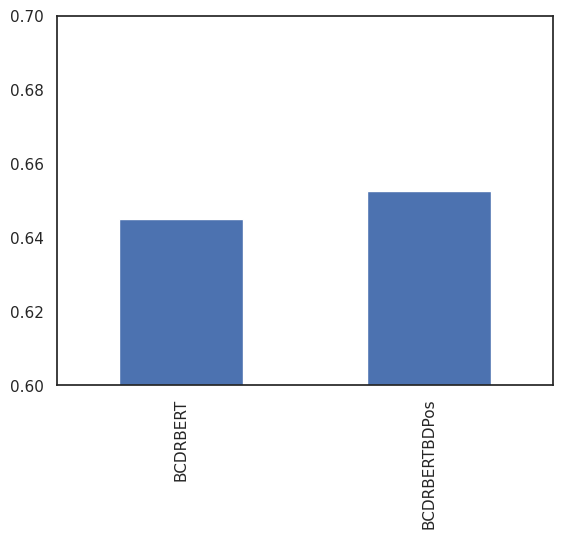

In [8]:
ax = clean_plot(dash_avg_precisions, ["BCDRBERT", "BCDRBERTBDPos"])
ax.set_ylim(0.6, 0.7)

In [9]:
def list_censoring_variants(base_name, censoring_type):
    return [f"{base_name} +ACL ({censoring_type} {level})" for level in ("0.01", "0.05", "0.10", "0.15", "0.20")]

(0.6, 0.7)

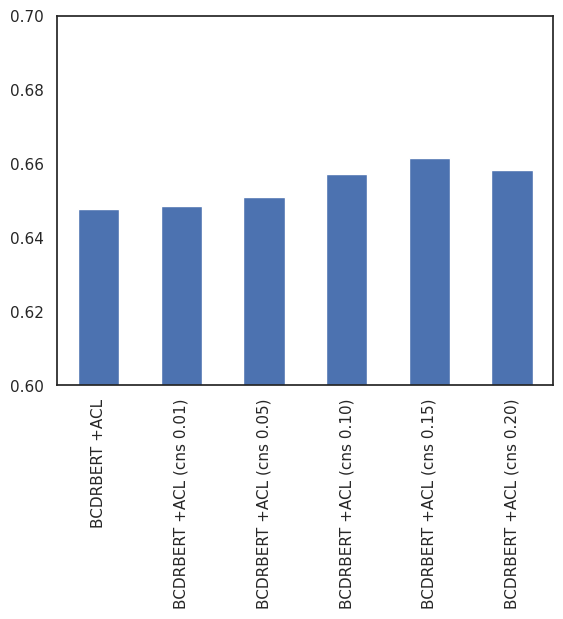

In [10]:
ax = clean_plot(dash_avg_precisions, ["BCDRBERT +ACL", *list_censoring_variants("BCDRBERT", "cns")])
ax.set_ylim(0.6, 0.7)

(0.6, 0.7)

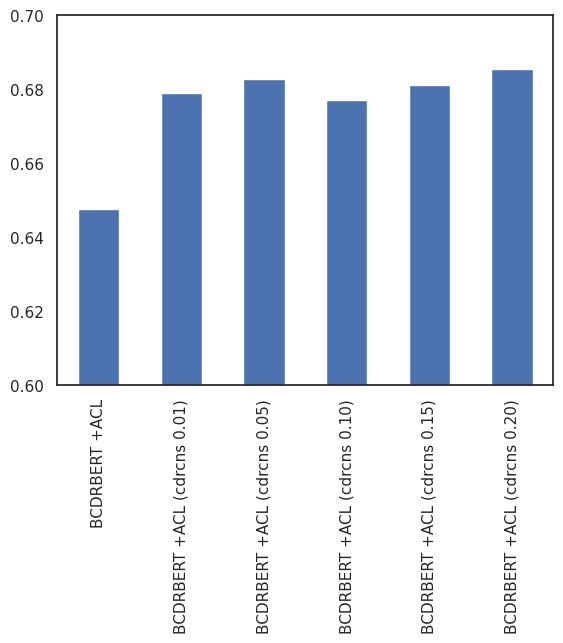

In [11]:
ax = clean_plot(dash_avg_precisions, ["BCDRBERT +ACL", *list_censoring_variants("BCDRBERT", "cdrcns")])
ax.set_ylim(0.6, 0.7)

(0.6, 0.7)

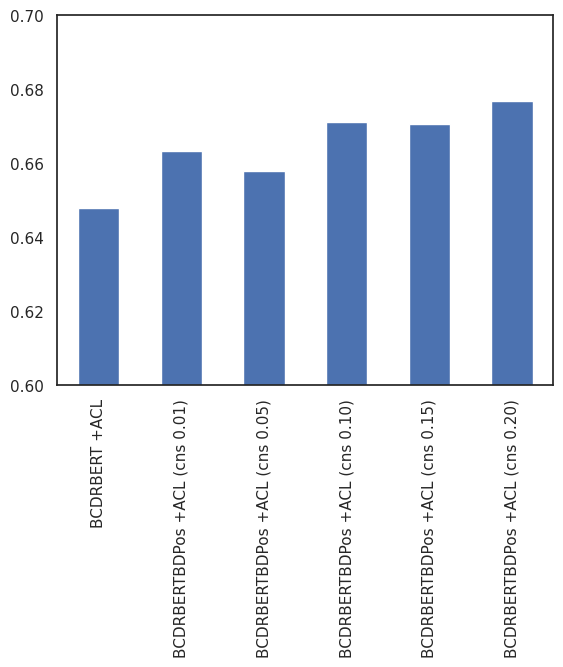

In [12]:
ax = clean_plot(dash_avg_precisions, ["BCDRBERT +ACL", *list_censoring_variants("BCDRBERTBDPos", "cns")])
ax.set_ylim(0.6, 0.7)

(0.6, 0.7)

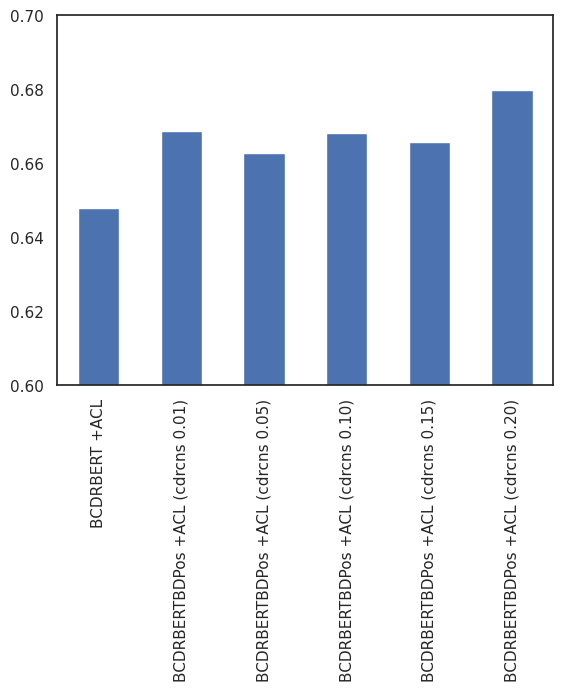

In [12]:
ax = clean_plot(dash_avg_precisions, ["BCDRBERT +ACL", *list_censoring_variants("BCDRBERTBDPos", "cdrcns")])
ax.set_ylim(0.6, 0.7)

### VDJdb

In [6]:
vdjdb_avg_precisions = {mdict["model_name"]: mdict["vdjdb"]["avg_precision"] for mdict in metric_dicts}
vdjdb_avg_precisions = pd.DataFrame.from_dict(vdjdb_avg_precisions, orient="index")
vdjdb_avg_precisions = vdjdb_avg_precisions.sort_values(by=0)

<AxesSubplot: >

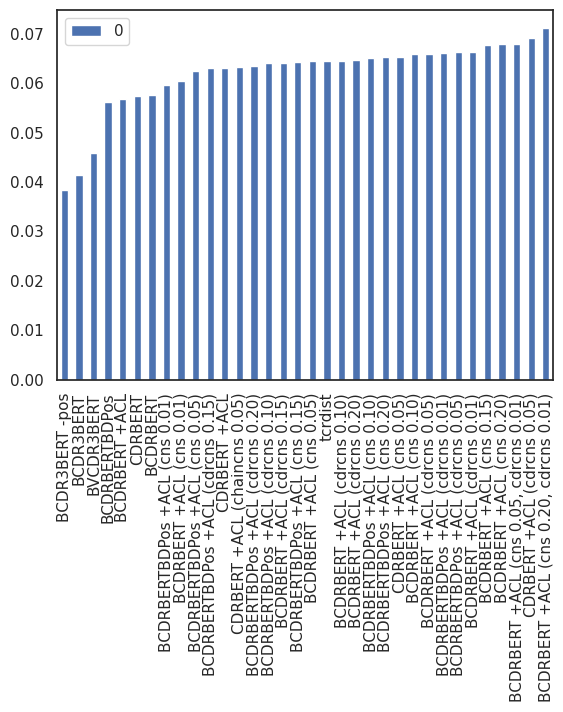

In [7]:
vdjdb_avg_precisions.plot(kind="bar")

(0.05, 0.08)

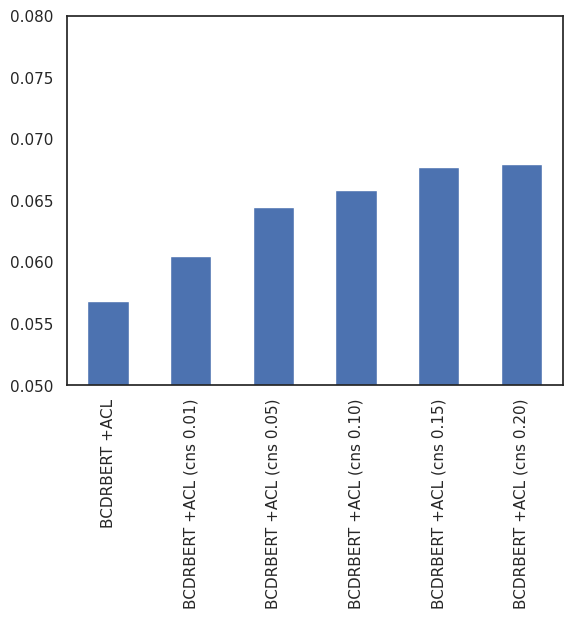

In [29]:
ax = clean_plot(vdjdb_avg_precisions, ["BCDRBERT +ACL", *list_censoring_variants("BCDRBERT", "cns")])
ax.set_ylim(0.05, 0.08)

(0.05, 0.08)

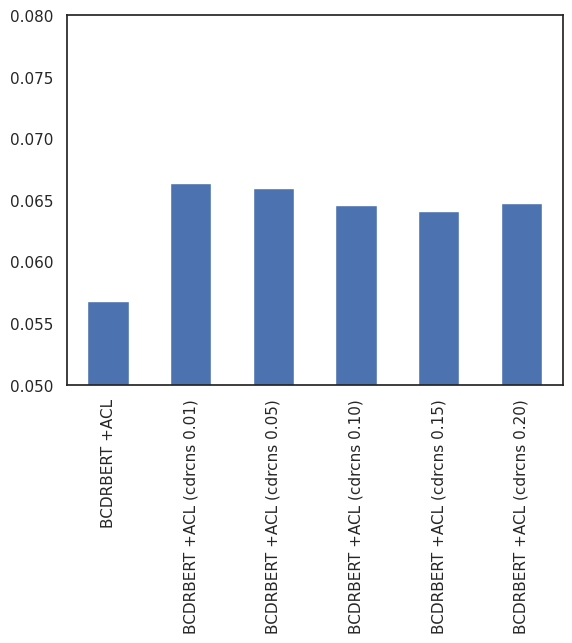

In [30]:
ax = clean_plot(vdjdb_avg_precisions, ["BCDRBERT +ACL", *list_censoring_variants("BCDRBERT", "cdrcns")])
ax.set_ylim(0.05, 0.08)

(0.05, 0.08)

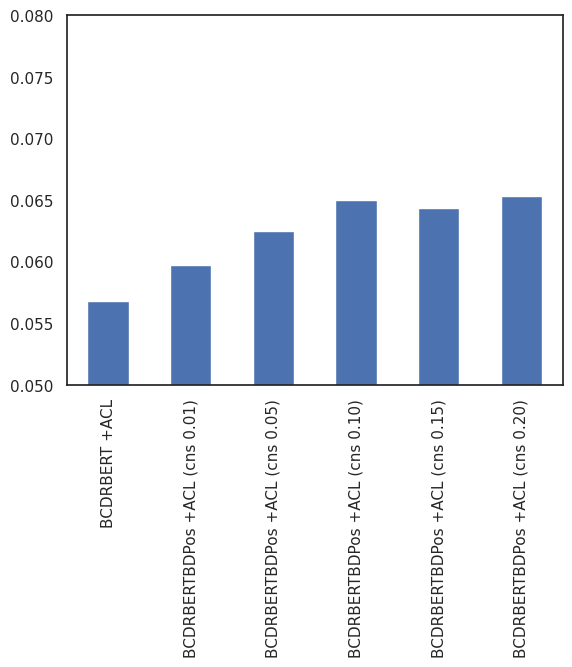

In [31]:
ax = clean_plot(vdjdb_avg_precisions, ["BCDRBERT +ACL", *list_censoring_variants("BCDRBERTBDPos", "cns")])
ax.set_ylim(0.05, 0.08)

(0.05, 0.08)

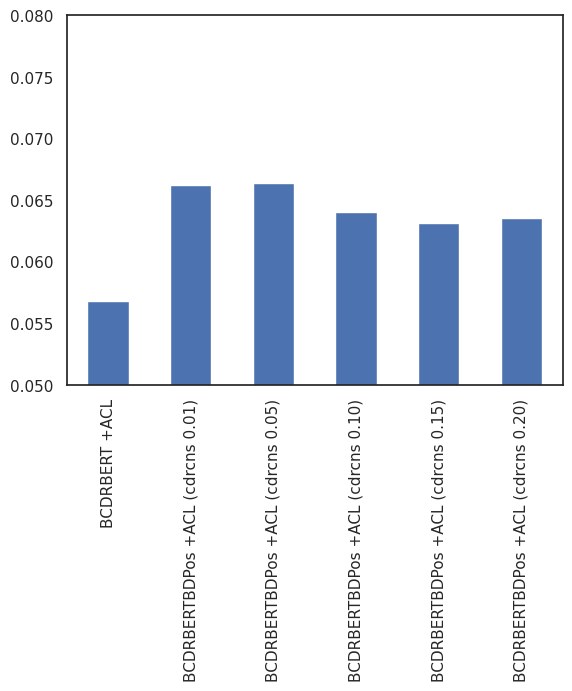

In [25]:
ax = clean_plot(vdjdb_avg_precisions, ["BCDRBERT +ACL", *list_censoring_variants("BCDRBERTBDPos", "cdrcns")])
ax.set_ylim(0.05, 0.08)

(0.05, 0.08)

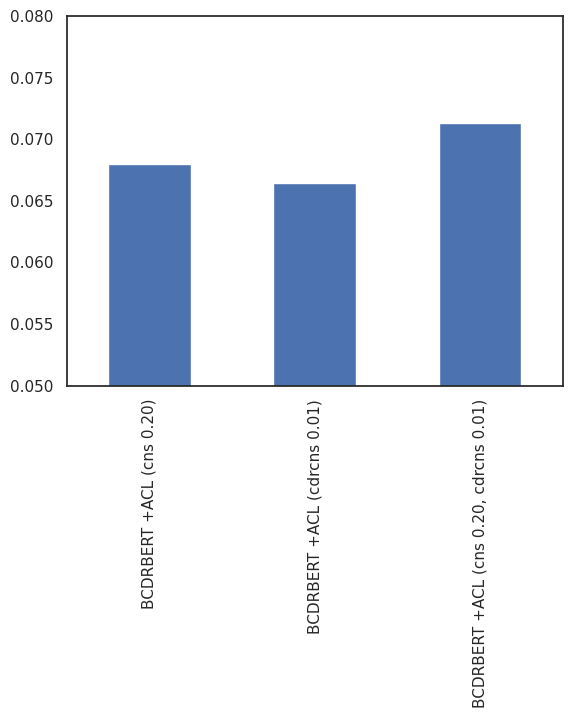

In [9]:
ax = clean_plot(vdjdb_avg_precisions, ["BCDRBERT +ACL (cns 0.20)", "BCDRBERT +ACL (cdrcns 0.01)", "BCDRBERT +ACL (cns 0.20, cdrcns 0.01)"])
ax.set_ylim(0.05, 0.08)

## PR curves

### Dash

In [11]:
def plot_pr_curve(ax, model_name, dataset, color):
    precisions = np.load(BENCHMARKING_PARENT_DIR/model_name/f"{dataset}_precisions.npy")
    recalls = np.load(BENCHMARKING_PARENT_DIR/model_name/f"{dataset}_recalls.npy")

    ax.step(recalls, precisions, c=color, label=model_name)

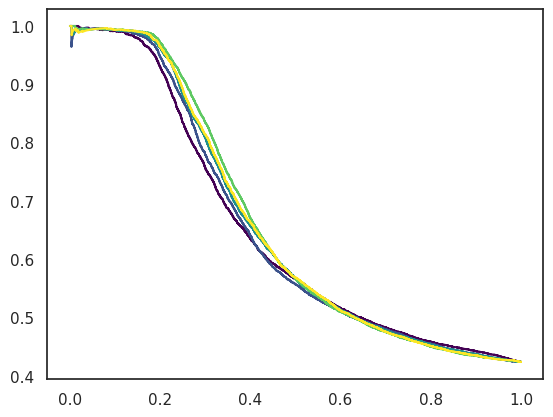

In [38]:
fig, ax = plt.subplots()

models = list_censoring_variants("BCDRBERT", "cns")
colors = pl.cm.viridis(np.linspace(0, 1, len(models)))

for i, model in enumerate(models):
    plot_pr_curve(ax, model, "dash", colors[i])

plt.show()

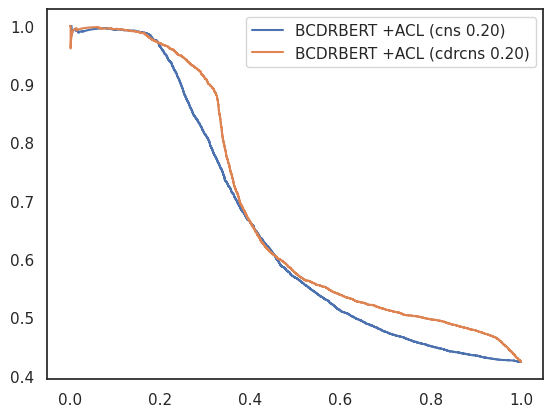

In [19]:
fig, ax = plt.subplots()

models = ["BCDRBERT +ACL (cns 0.20)", "BCDRBERT +ACL (cdrcns 0.20)"]

for i, model in enumerate(models):
    plot_pr_curve(ax, model, "dash", f"C{i}")

plt.legend()
plt.show()

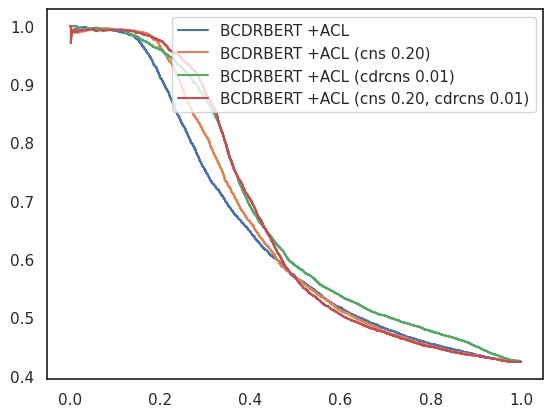

In [13]:
fig, ax = plt.subplots()

models = ["BCDRBERT +ACL", "BCDRBERT +ACL (cns 0.20)", "BCDRBERT +ACL (cdrcns 0.01)", "BCDRBERT +ACL (cns 0.20, cdrcns 0.01)"]

for i, model in enumerate(models):
    plot_pr_curve(ax, model, "dash", f"C{i}")

plt.legend()
plt.show()

### VDJdb

NameError: name 'list_censoring_variants' is not defined

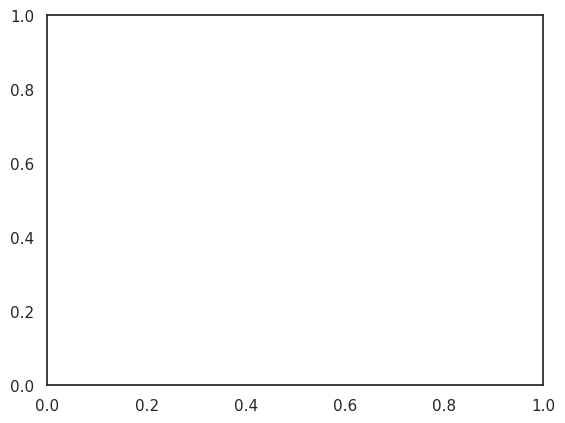

In [8]:
fig, ax = plt.subplots()

models = list_censoring_variants("BCDRBERTBDPos", "cdrcns")
colors = pl.cm.viridis(np.linspace(0, 1, len(models)))

for i, model in enumerate(models):
    plot_pr_curve(ax, model, "vdjdb", colors[i])

ax.set_xlim(0, 0.05)
plt.show()

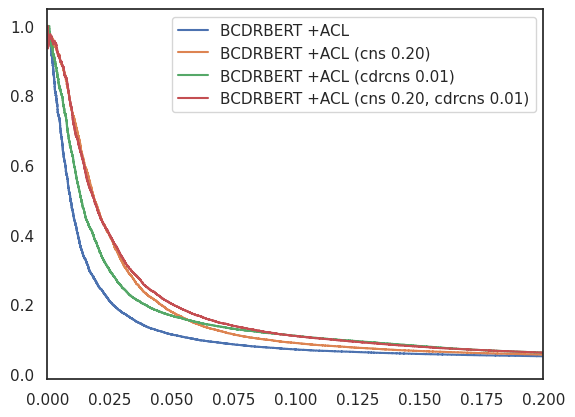

In [12]:
fig, ax = plt.subplots()

models = ["BCDRBERT +ACL", "BCDRBERT +ACL (cns 0.20)", "BCDRBERT +ACL (cdrcns 0.01)", "BCDRBERT +ACL (cns 0.20, cdrcns 0.01)"]

for i, model in enumerate(models):
    plot_pr_curve(ax, model, "vdjdb", f"C{i}")

ax.set_xlim(0, 0.2)
plt.legend()
plt.show()

## k-NN Scores

### VDJdb

In [13]:
knn_scores = {mdict['model_name']: mdict['vdjdb']['knn_scores'] for mdict in metric_dicts}
knn_scores = pd.DataFrame.from_dict(knn_scores, orient='index')
knn_scores = knn_scores.sort_values(by='5')
knn_scores.columns = knn_scores.columns.map(lambda x: f'k={x}')

In [14]:
knn_scores

,k=5,k=10,k=50,k=100
BCDR3BERT -pos,0.118621,0.118621,0.110345,0.111379
BCDR3BERT,0.156897,0.161724,0.146207,0.142414
BCDR3Levenshtein,0.182759,0.180690,0.162414,0.151724
BVCDR3BERT,0.189310,0.192759,0.174828,0.159655
CDRBERT,0.203793,0.210690,0.222414,0.206552
BCDRBERT,0.212414,0.217586,0.220690,0.207931
BCDRBERTBDPos,0.214483,0.214138,0.222069,0.214138
CDRBERT +ACL (cdrcns 0.05),0.231379,0.231034,0.224483,0.213793
CDRBERT +ACL (cns 0.05),0.239310,0.246897,0.226897,0.212069
BCDRBERT +ACL,0.241379,0.255172,0.228966,0.225862


In [15]:
def knn_plot(models):
    embedding_info = knn_scores.loc[models]
    embedding_info_plot = embedding_info.plot(kind='bar')
    plt.ylabel('knn score')
    plt.xlabel('model name')
    plt.axhline(1/29, color='tab:grey', linestyle='dashed')
    seaborn.move_legend(embedding_info_plot, 'upper left', bbox_to_anchor=(1, 1))
    return embedding_info_plot

### Vs Levenshtein

<AxesSubplot: xlabel='model name', ylabel='knn score'>

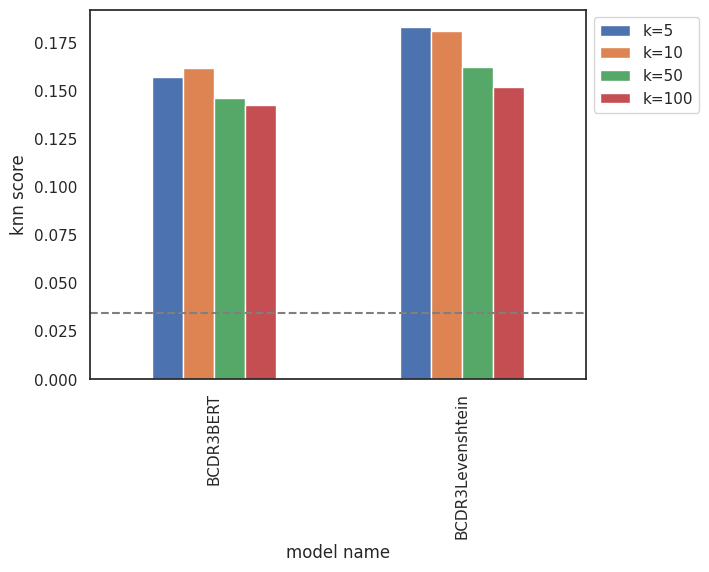

In [17]:
knn_plot(['BCDR3BERT', 'BCDR3Levenshtein'])

### Does it learn better if you add positional info?

<AxesSubplot: xlabel='model name', ylabel='knn score'>

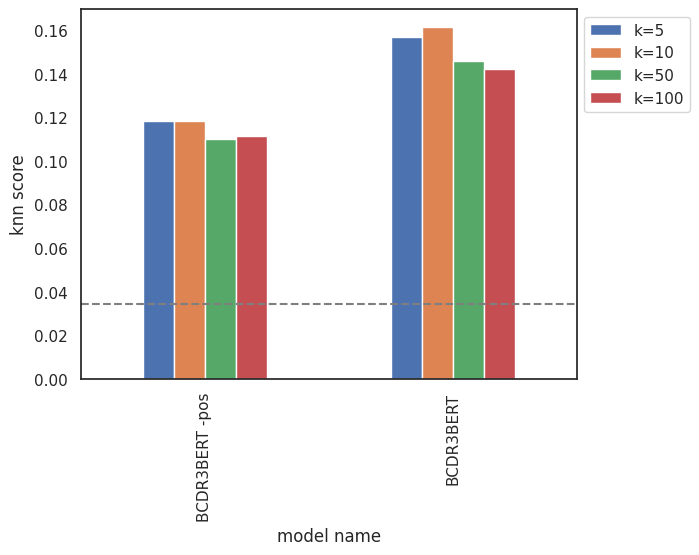

In [16]:
knn_plot(['BCDR3BERT -pos', 'BCDR3BERT'])

### Does it learn better with V gene info?

<AxesSubplot: xlabel='model name', ylabel='knn score'>

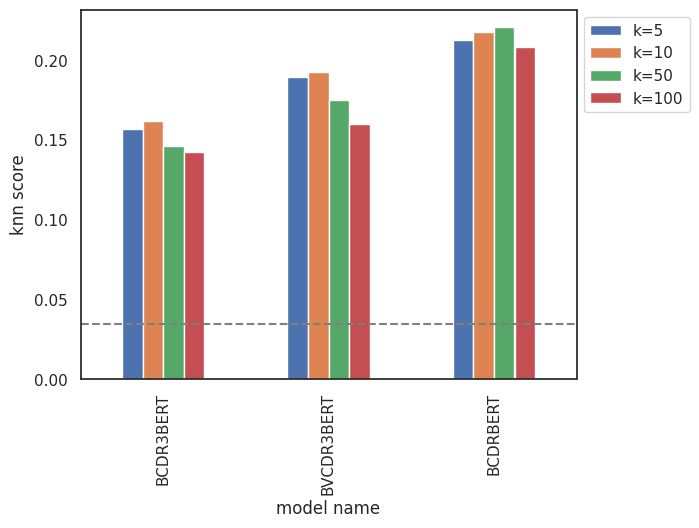

In [18]:
knn_plot(['BCDR3BERT', 'BVCDR3BERT', 'BCDRBERT'])

### Does it learn with autocontrastive learning?

<AxesSubplot: xlabel='model name', ylabel='knn score'>

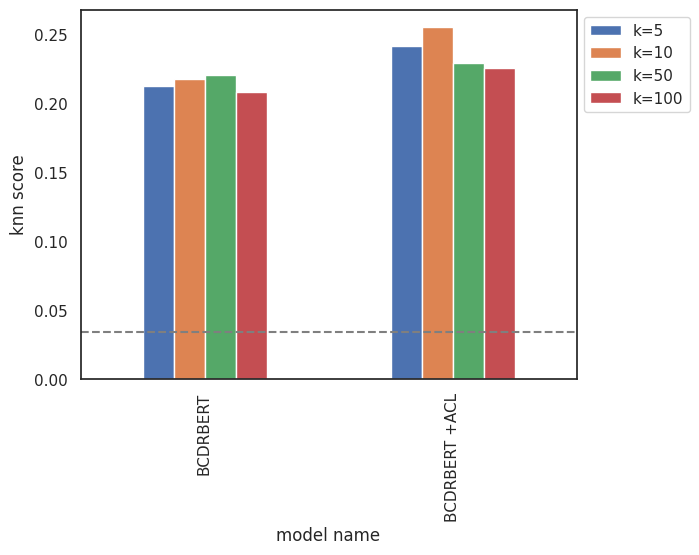

In [19]:
knn_plot(['BCDRBERT', 'BCDRBERT +ACL'])

### Does autocontrastive learning work better with censoring?

(0.2, 0.3)

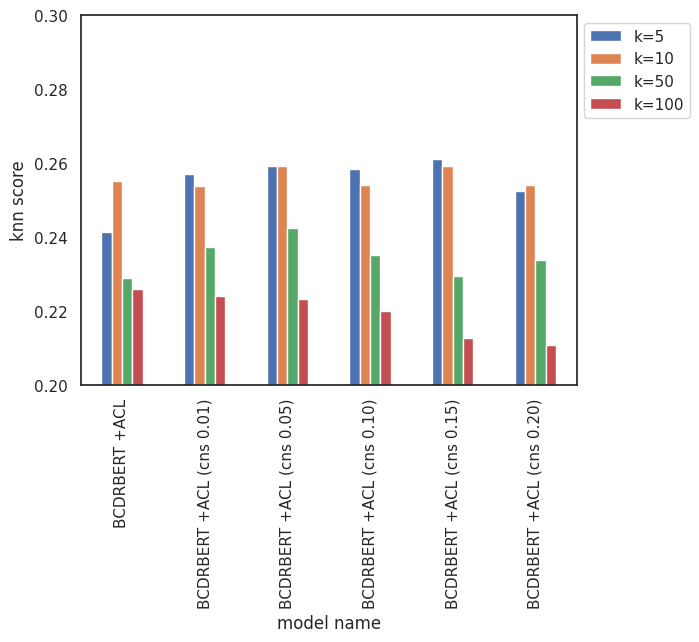

In [23]:
ax = knn_plot(['BCDRBERT +ACL', *list_censoring_variants("BCDRBERT", "cns")])
ax.set_ylim(0.2, 0.3)

<AxesSubplot: xlabel='model name', ylabel='knn score'>

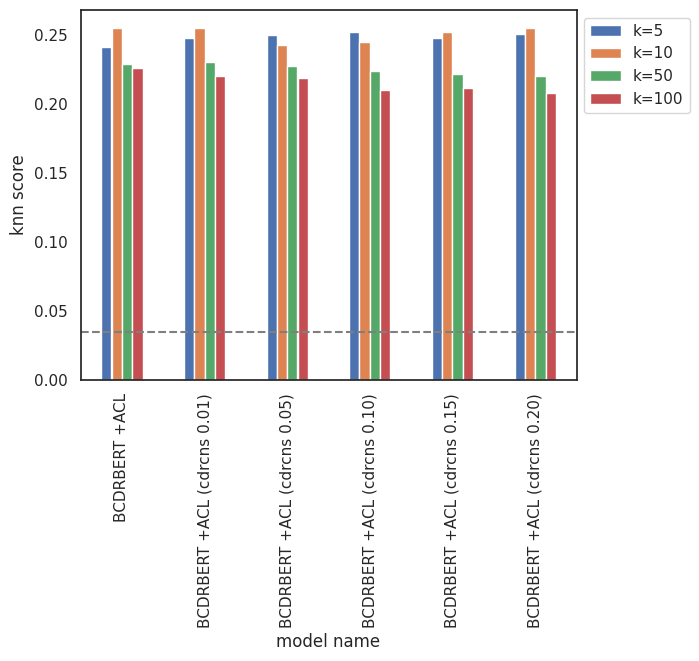

In [24]:
knn_plot(['BCDRBERT +ACL', 'BCDRBERT +ACL (cdrcns 0.01)', 'BCDRBERT +ACL (cdrcns 0.05)', 'BCDRBERT +ACL (cdrcns 0.10)', 'BCDRBERT +ACL (cdrcns 0.15)', 'BCDRBERT +ACL (cdrcns 0.20)'])

### What happens if we train with paired-chain data?

<AxesSubplot: xlabel='model name', ylabel='knn score'>

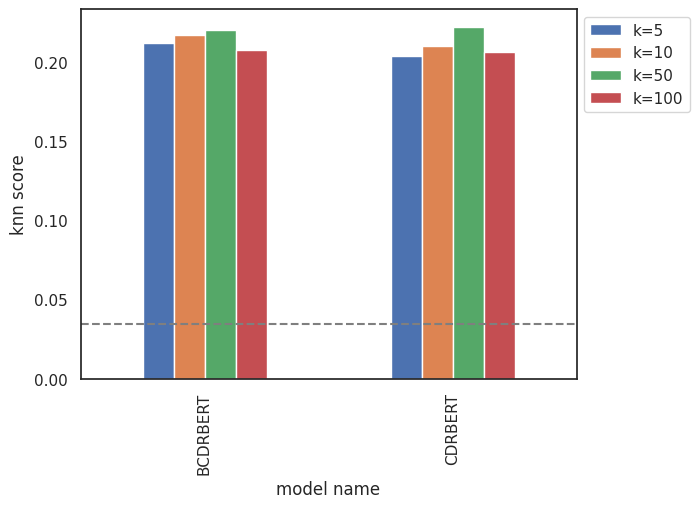

In [25]:
knn_plot(['BCDRBERT', 'CDRBERT'])

<AxesSubplot: xlabel='model name', ylabel='knn score'>

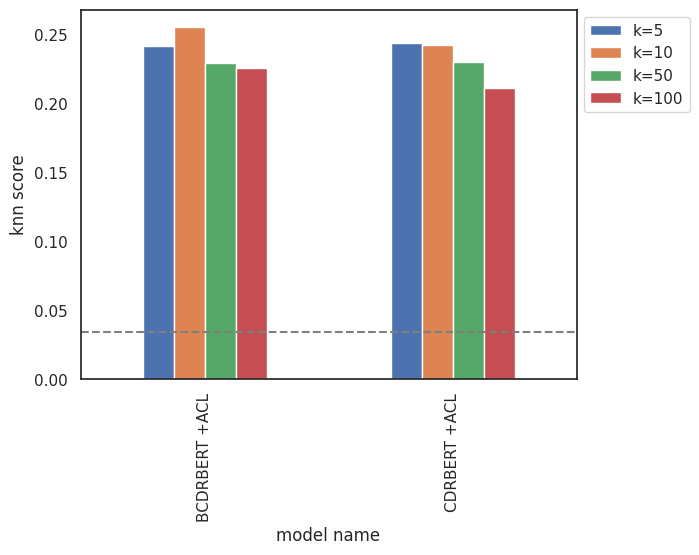

In [26]:
knn_plot(['BCDRBERT +ACL', 'CDRBERT +ACL'])

### VS tcrdist

(0.2, 0.26)

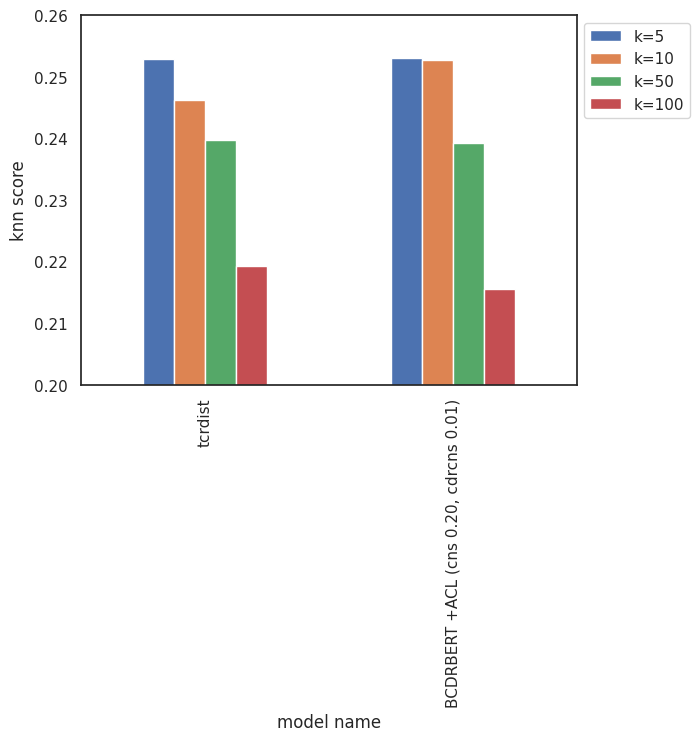

In [17]:
ax = knn_plot(['tcrdist', 'BCDRBERT +ACL (cns 0.20, cdrcns 0.01)'])
ax.set_ylim(0.20, 0.26)

(0.2, 0.27)

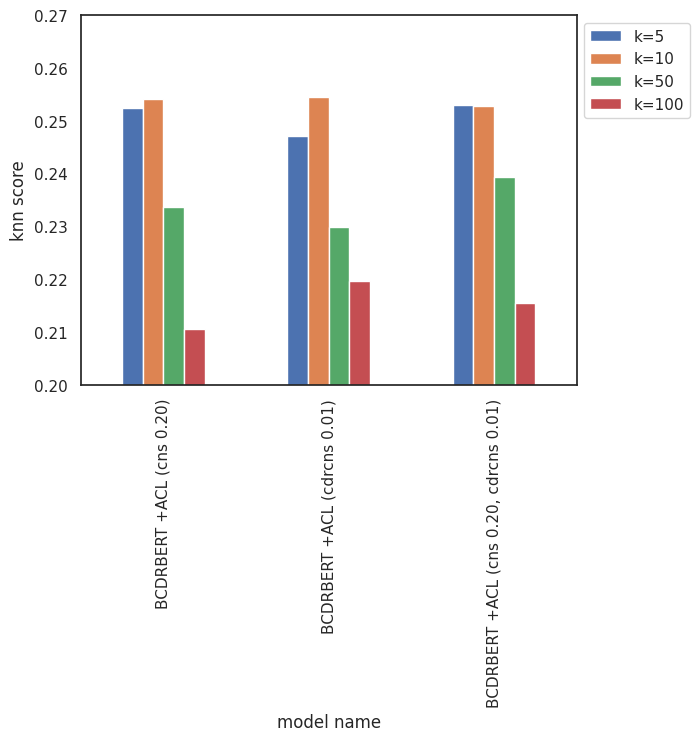

In [30]:
ax = knn_plot(['BCDRBERT +ACL (cns 0.20)', 'BCDRBERT +ACL (cdrcns 0.01)', 'BCDRBERT +ACL (cns 0.20, cdrcns 0.01)'])
ax.set_ylim(0.2, 0.27)

## Alignment and Uniformity

In [18]:
alnunf = {mdict['model_name']: {'alignment': mdict['alignment'], 'uniformity': mdict['uniformity'], '5nn accuracy': mdict['knn_scores']['5']} for mdict in metric_dicts}
alnunf = pd.DataFrame.from_dict(alnunf, orient='index')
alnunf = alnunf.sort_index()
alnunf['alignment + uniformity'] = alnunf['alignment'] + alnunf['uniformity']
alnunf['-uniformity'] = -alnunf['uniformity']
alnunf = alnunf[alnunf.index != 'CDR3 Levenshtein']

### Alignment + uniformity vs 5-NN performance

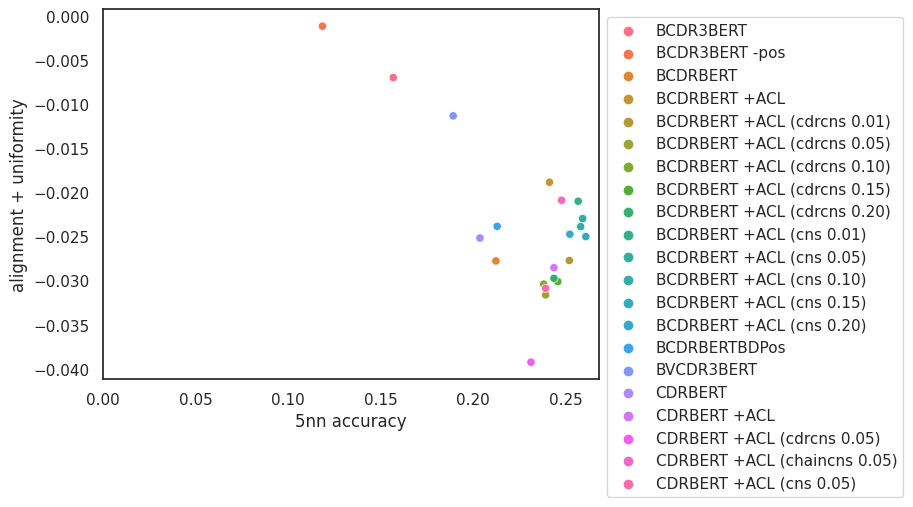

In [19]:
scatter_model_names = seaborn.scatterplot(alnunf, x='5nn accuracy', y='alignment + uniformity', hue=alnunf.index)
scatter_model_names.set_xlim(0)
seaborn.move_legend(scatter_model_names, 'upper left', bbox_to_anchor=(1, 1))
plt.show()

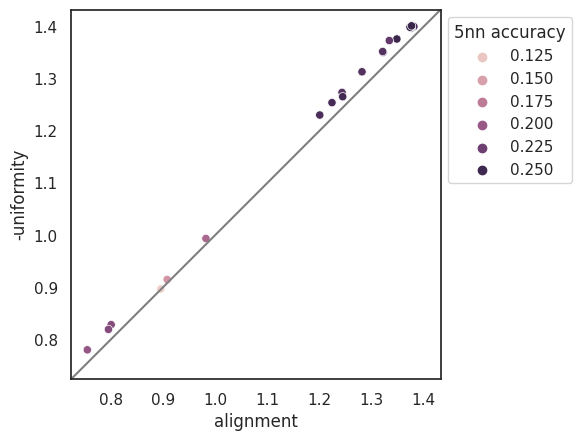

In [20]:
scatter_model_names = seaborn.scatterplot(alnunf, x='alignment', y='-uniformity', hue='5nn accuracy')

lims = [
    min([*scatter_model_names.get_xlim(), *scatter_model_names.get_ylim()]),
    max([*scatter_model_names.get_xlim(), *scatter_model_names.get_ylim()])
]
scatter_model_names.plot(lims, lims, color='grey')
scatter_model_names.set_aspect('equal')
scatter_model_names.set_xlim(lims)
scatter_model_names.set_ylim(lims)

seaborn.move_legend(scatter_model_names, 'upper left', bbox_to_anchor=(1, 1))
plt.show()